## End member mixing analysis (EMMA) to determine streamflow source contributions

### Finally running an EMMA using linear regression.​

#### Here we started with solute data from Hungerford Brook late winter/early spring flow events captured with ISCOs. Data include:
- ICP-OES (Al, Ca, Cu, Fe, K, Mg, Mn, Na, P, Zn, Si
- IC and total elemental analyser data (Cl, SO4, NO3, PO4, TOC, DIN)
- Stable isotopes (dD, d18O)

Data are from the BREE OneDrive directory (Watershed Data>1_Projects>EMMA>Working file for MATLAB 2023)

- For HB 2022 timeseries, 17 parameters total
- 5 were found to be relatively conservative: Cl, Ca, Na, Si, and Mg
- See "bivariates" notebook for those plots

This code utilizes the minimize function from SciPy to find fractions that meet the specified constraints. The objective function minimizes the difference between the observed and predicted observations, subject to the constraints on the fractions.

In [1]:
import os
os.chdir("/home/millieginty/OneDrive/git-repos/EMMA/")

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

###################
# SET DIRECTORIES #
###################

#input_dir <- "/home/millieginty/OneDrive/git-repos/EMMA/data"
#output_dir <- "~//OneDrive/git-repos/cQ_analysis/hydrun/output/"

# Load streamflow data from the CSV file
streamflow_data = pd.read_csv("data/newrnet-chemistry/Data_for_EMMA_2022_HB.csv")

# Load potential endmembers from the separate CSV file
endmember_data = pd.read_csv("data/newrnet-chemistry/end_members_2022_HB_mean_for_emma.csv")

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']

# Extract the subset of data for selected parameters in endmembers
subset_endmembers = endmember_data[selected_parameters]

# Standardize the endmember data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_endmembers = scaler.fit_transform(subset_endmembers)

# Apply PCA to endmember data
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

# Apply PCA to streamflow data
pca_streamflow = PCA(n_components=2)
pca_result_streamflow = pca_streamflow.fit_transform(scaler.transform(streamflow_data[selected_parameters]))

# Function to calculate the objective function
def objective_function(Ii, xi, B):
    xi_pred = np.dot(Ii, B)
    return np.linalg.norm(xi - xi_pred)

# Constraints
constraints = ({'type': 'eq', 'fun': lambda Ii: np.sum(Ii) - 1},  # Sum of fractions is 1
               {'type': 'ineq', 'fun': lambda Ii: Ii},  # Fractions are non-negative
               {'type': 'ineq', 'fun': lambda Ii: 1 - Ii})  # Fractions are less than or equal to 1

# Solve for fractions using optimization
fractions = []

for i in range(len(streamflow_data)):
    # Extract PCA vector for the current streamflow sample
    pca_vector_streamflow = pca_result_streamflow[i, :].reshape(1, -1)

    # Initialize fractions with equal weights
    initial_guess = np.ones(pca_result_endmembers.shape[0]) / pca_result_endmembers.shape[0]

    # Optimization to find fractions
    result = minimize(objective_function, initial_guess, args=(pca_vector_streamflow, pca_result_endmembers),
                      constraints=constraints, method='SLSQP')

    # Append the fractions for the current observation
    fractions_i = result.x
    fractions.append(fractions_i)

# Stack fractions into a numpy array
fractions = np.vstack(fractions)

# Create a DataFrame with the information
fractions_df = pd.DataFrame(fractions, columns=endmember_data['Type'])
fractions_df['Sample ID'] = streamflow_data['Sample ID']
fractions_df['Date'] = streamflow_data['Date']
fractions_df['Time'] = streamflow_data['Time']
#fractions_df['Sum Fractions'] = fractions_df.sum(axis=1) #was giving error 2025-03-19 need to figure out but works without

# Convert Date and Time strings to combined Datetime that we'll index
fractions_df['Datetime'] = pd.to_datetime(fractions_df['Date'] + ' ' + fractions_df['Time'])

fractions_df.head(20)

/tmp/ipykernel_95461/85228832.py:77: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fractions_df['Datetime'] = pd.to_datetime(fractions_df['Date'] + ' ' + fractions_df['Time'])


Type,Precipitation,Snow lysimeter,Groundwater,Sample ID,Date,Time,Datetime
0,0.181685,0.180016,0.638299,RI22-0254,2/16/22,13:45,2022-02-16 13:45:00
1,0.458837,0.479020,0.062143,RI22-0113,2/17/22,20:00,2022-02-17 20:00:00
2,0.484513,0.468663,0.046824,RI22-0114,2/17/22,22:00,2022-02-17 22:00:00
3,0.450046,0.476431,0.073523,RI22-0112,2/17/22,18:00,2022-02-17 18:00:00
4,0.451746,0.446546,0.101708,RI22-0110,2/17/22,14:00,2022-02-17 14:00:00
5,0.450857,0.417853,0.131290,RI22-0111,2/17/22,16:00,2022-02-17 16:00:00
6,0.182969,0.150179,0.666851,RI22-0260,2/17/22,10:00,2022-02-17 10:00:00
7,0.179697,0.153324,0.666979,RI22-0258,2/17/22,2:00,2022-02-17 02:00:00
8,0.178897,0.178336,0.642767,RI22-0259,2/17/22,6:00,2022-02-17 06:00:00
9,0.470040,0.455097,0.074863,RI22-0115,2/18/22,0:00,2022-02-18 00:00:00


In [3]:
pca_vector_streamflow

array([[ 0.25962267, -0.01297293]])

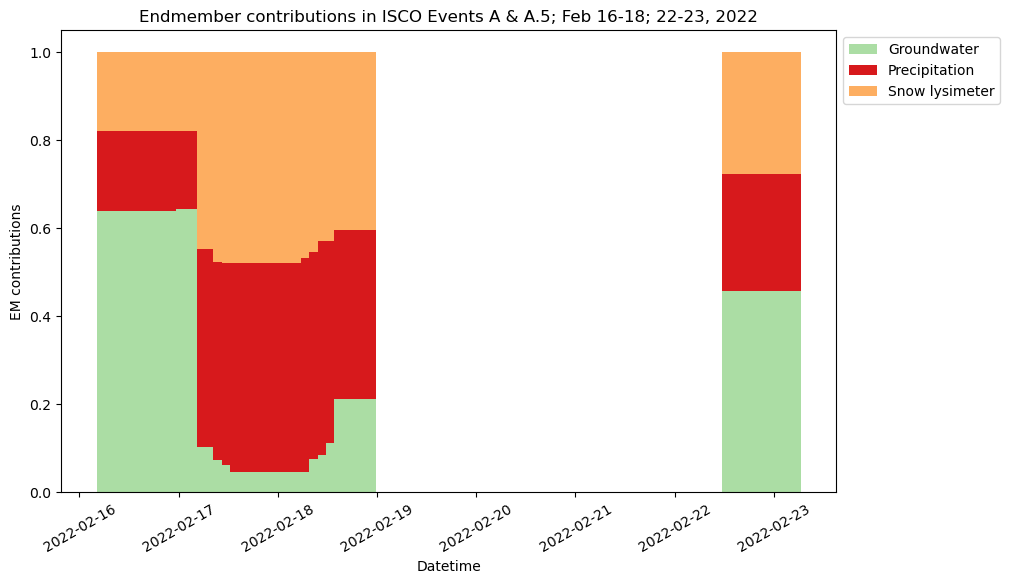

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# fractions_df = ... see above

# Filter data for samples in Event A & 'A.5'
event1_df = fractions_df[(fractions_df['Datetime'] >= '2022-02-16 00:00:00') & (fractions_df['Datetime'] <= '2022-02-23 00:00:00')]

# Set 'Datetime' as the index
event1_df.set_index('Datetime', inplace=True)

# Define colors for each endmember
colors = {'Groundwater': '#abdda4', 'Precipitation': '#d7191c', 'Snow lysimeter': '#fdae61'}

# Plot stacked bar chart
plt.figure(figsize=(10, 6))

bottom = None
for column, color in colors.items():
    plt.bar(event1_df.index, event1_df[column], label=column, color=color, bottom=bottom)
    if bottom is None:
        bottom = event1_df[column].values
    else:
        bottom += event1_df[column].values

plt.xlabel('Datetime')
plt.ylabel('EM contributions')
plt.title('Endmember contributions in ISCO Events A & A.5; Feb 16-18; 22-23, 2022')

# Rotate x-axis tick labels
plt.xticks(rotation=30)

# Place legend outside the plot on the left
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

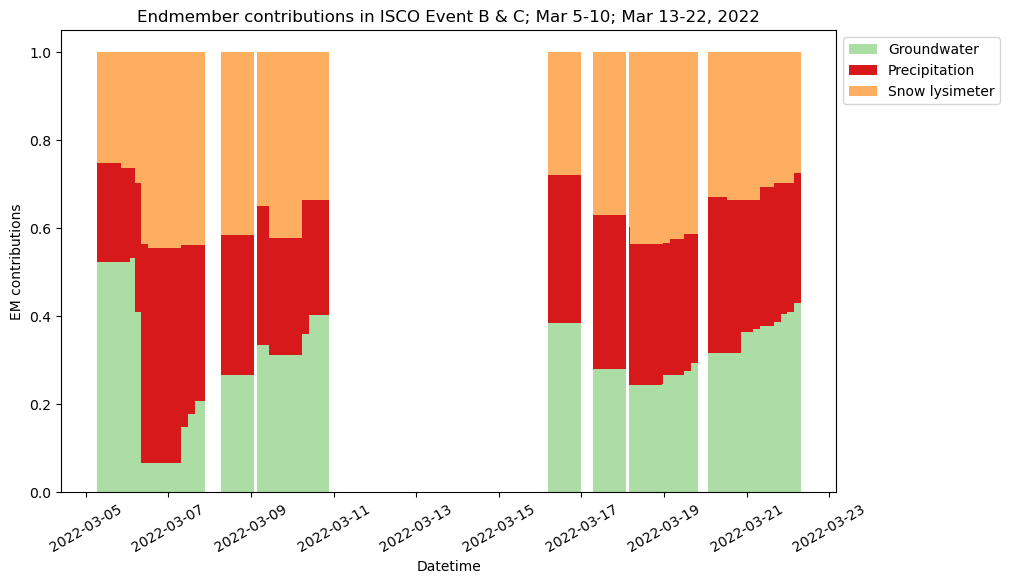

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# fractions_df = ... see above

# Filter data for samples in Events B & C
event1_df = fractions_df[(fractions_df['Datetime'] >= '2022-03-05 00:00:00') & (fractions_df['Datetime'] <= '2022-03-22 00:00:00')]

# Set 'Datetime' as the index
event1_df.set_index('Datetime', inplace=True)

# Define colors for each endmember
colors = {'Groundwater': '#abdda4', 'Precipitation': '#d7191c', 'Snow lysimeter': '#fdae61'}

# Plot stacked bar chart
plt.figure(figsize=(10, 6))

bottom = None
for column, color in colors.items():
    plt.bar(event1_df.index, event1_df[column], label=column, color=color, bottom=bottom)
    if bottom is None:
        bottom = event1_df[column].values
    else:
        bottom += event1_df[column].values

plt.xlabel('Datetime')
plt.ylabel('EM contributions')
plt.title('Endmember contributions in ISCO Event B & C; Mar 5-10; Mar 13-22, 2022')

# Rotate x-axis tick labels
plt.xticks(rotation=30)

# Place legend outside the plot on the left
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

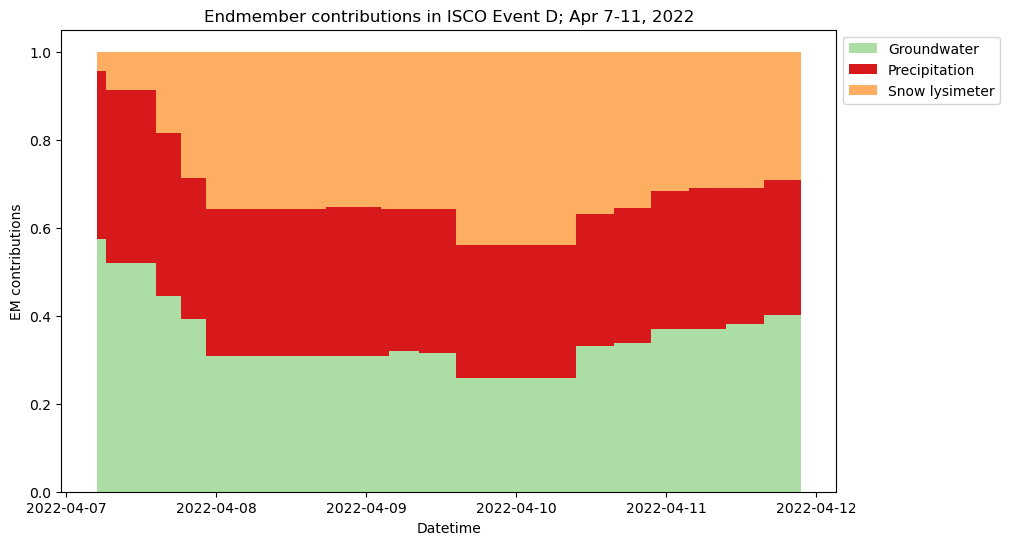

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# fractions_df = ... see above

# Filter data for samples in Event D
event1_df = fractions_df[(fractions_df['Datetime'] >= '2022-04-07 00:00:00') & (fractions_df['Datetime'] <= '2022-04-12 00:00:00')]

# Set 'Datetime' as the index
event1_df.set_index('Datetime', inplace=True)

# Define colors for each endmember
colors = {'Groundwater': '#abdda4', 'Precipitation': '#d7191c', 'Snow lysimeter': '#fdae61'}

# Plot stacked bar chart
plt.figure(figsize=(10, 6))

bottom = None
for column, color in colors.items():
    plt.bar(event1_df.index, event1_df[column], label=column, color=color, bottom=bottom)
    if bottom is None:
        bottom = event1_df[column].values
    else:
        bottom += event1_df[column].values

plt.xlabel('Datetime')
plt.ylabel('EM contributions')
plt.title('Endmember contributions in ISCO Event D; Apr 7-11, 2022')

# Place legend outside the plot on the left
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

/tmp/ipykernel_95461/3038971897.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  streamflow_data['datetime'] = pd.to_datetime(streamflow_data['Date'] + ' ' + streamflow_data['Time'])
/tmp/ipykernel_95461/3038971897.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  endmember_data['datetime'] = pd.to_datetime(endmember_data['Date'] + ' ' + endmember_data['Time'])
/tmp/ipykernel_95461/3038971897.py:89: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fractions_df['datetime'] = pd.to_datetime(fractions_df['Date'] + ' ' + fractions_df['Time'])


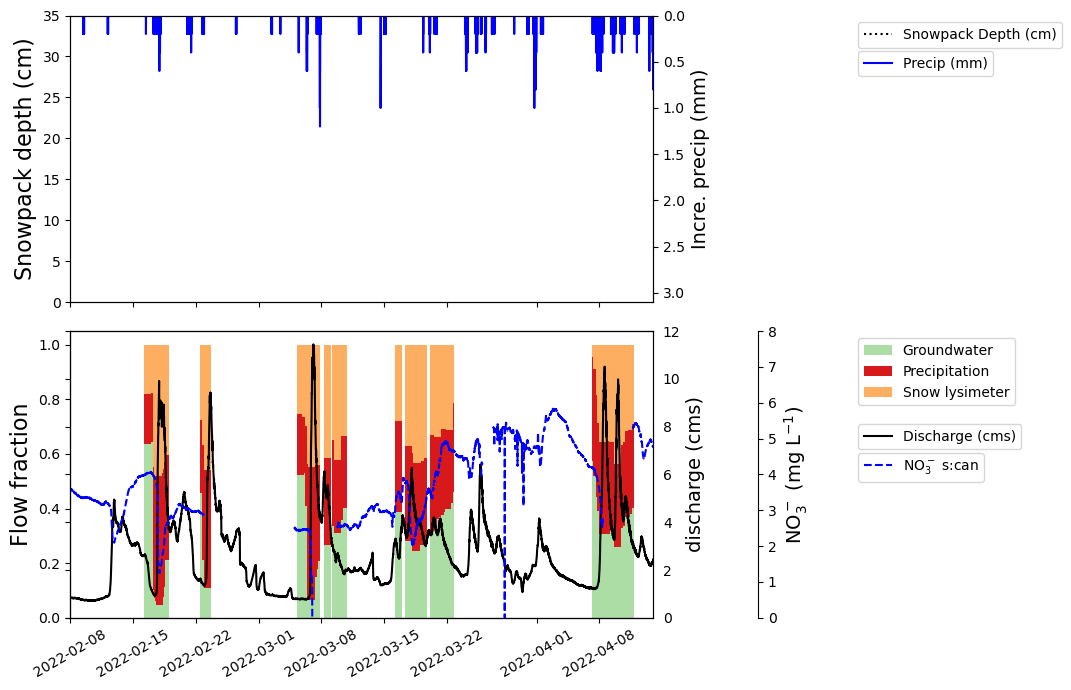

In [7]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load streamflow data from the CSV file
streamflow_data = pd.read_csv("data/newrnet-chemistry/Data_for_EMMA_2022_HB.csv")

# Load s::can NO3 and TP data from csv
scan_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/sonya-may24/data/hb_q_chem copy.csv")

soil_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/EMMA/data/soil-sensor/Temperature.SoilTemp_15cm@HD_pit1.20210801.csv")

met_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/LCBP_Soils/OriginalData/met-station/hungerford_2020-2024_met_2024-11-08.csv")
met_data['datetime'] = pd.to_datetime(met_data['Timestamp'])

# Load snowpack depth data from Enosbery Falls 2.5N NOAA station
snowpack_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/LCBP_Soils/OriginalData/met-station/enf-noaa-WYW22.csv")
snowpack_data['datetime'] = pd.to_datetime(snowpack_data['Date'], format="%Y-%m-%d %H", errors="coerce")

# Convert Date and Time strings to combined datetime that we'll index
streamflow_data['datetime'] = pd.to_datetime(streamflow_data['Date'] + ' ' + streamflow_data['Time'])

# Load potential endmembers from the separate CSV file
endmember_data = pd.read_csv("data/newrnet-chemistry/end_members_2022_HB_mean_for_emma.csv")

# Convert Date and Time strings to combined datetime that we'll index
endmember_data['datetime'] = pd.to_datetime(endmember_data['Date'] + ' ' + endmember_data['Time'])

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']

# Extract the subset of data for selected parameters in endmembers
subset_endmembers = endmember_data[selected_parameters]

# Standardize the endmember data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_endmembers = scaler.fit_transform(subset_endmembers)

# Apply PCA to endmember data
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

# Apply PCA to streamflow data
pca_streamflow = PCA(n_components=2)
pca_result_streamflow = pca_streamflow.fit_transform(scaler.transform(streamflow_data[selected_parameters]))

# Function to calculate the objective function
def objective_function(Ii, xi, B):
    xi_pred = np.dot(Ii, B)
    return np.linalg.norm(xi - xi_pred)

# Constraints
constraints = ({'type': 'eq', 'fun': lambda Ii: np.sum(Ii) - 1},  # Sum of fractions is 1
               {'type': 'ineq', 'fun': lambda Ii: Ii},  # Fractions are non-negative
               {'type': 'ineq', 'fun': lambda Ii: 1 - Ii})  # Fractions are less than or equal to 1

# Solve for fractions using optimization
fractions = []

for i in range(len(streamflow_data)):
    # Extract PCA vector for the current streamflow sample
    pca_vector_streamflow = pca_result_streamflow[i, :].reshape(1, -1)

    # Initialize fractions with equal weights
    initial_guess = np.ones(pca_result_endmembers.shape[0]) / pca_result_endmembers.shape[0]

    # Optimization to find fractions
    result = minimize(objective_function, initial_guess, args=(pca_vector_streamflow, pca_result_endmembers),
                      constraints=constraints, method='SLSQP')

    # Append the fractions for the current observation
    fractions_i = result.x
    fractions.append(fractions_i)

# Stack fractions into a numpy array
fractions = np.vstack(fractions)

# Create a DataFrame with the information
fractions_df = pd.DataFrame(fractions, columns=endmember_data['Type'])
fractions_df['Sample ID'] = streamflow_data['Sample ID']
fractions_df['Date'] = streamflow_data['Date']
fractions_df['Time'] = streamflow_data['Time']
#fractions_df['Sum Fractions'] = fractions_df.sum(axis=1)

# Convert Date and Time strings to combined datetime that we'll index
fractions_df['datetime'] = pd.to_datetime(fractions_df['Date'] + ' ' + fractions_df['Time'])

# Aggregate nitrate data for each date (using mean as an example)
nitrate_data_agg = streamflow_data.groupby('datetime')['NO3_mg_L'].mean().reset_index()
nitrate_scan_agg = scan_data.groupby('datetime')['NO3'].mean().reset_index()

# Convert 'Date' column to datetime if it's not already
nitrate_data_agg['datetime'] = pd.to_datetime(nitrate_data_agg['datetime'])
nitrate_scan_agg['datetime'] = pd.to_datetime(nitrate_scan_agg['datetime'])
scan_data['datetime'] = pd.to_datetime(scan_data['datetime'])

# Convert the timezone-aware datetime to timezone-naive
scan_data['datetime'] = pd.to_datetime(scan_data['datetime']).dt.tz_convert(None)

# Convert the timezone-aware datetime to timezone-naive
soil_data['ISO 8601 UTC'] = pd.to_datetime(soil_data['ISO 8601 UTC']).dt.tz_convert(None)

# Merge aggregated nitrate data with fractions_df on 'Date'
event1_df = pd.concat([fractions_df.set_index('datetime'), nitrate_data_agg.set_index('datetime')], axis=1)
#event1_df = pd.concat([fractions_df.set_index('datetime'), scan_data.set_index('datetime')], axis=1)

# Set 'datetime' as the index
event1_df.reset_index(inplace=True)

# Set 'datetime' as the index
event1_df.set_index('datetime', inplace=True)

# Define colors for each endmember
colors = {'Groundwater': '#abdda4', 'Precipitation': '#d7191c', 'Snow lysimeter': '#fdae61'}

# Plot stacked bar chart
#fig, ax1 = plt.subplots(figsize=(14, 6))

#bottom = None
#for column, color in colors.items():
    #ax1.bar(event1_df.index, event1_df[column], label=column, color=color, bottom=bottom)
    #if bottom is None:
        #bottom = event1_df[column].values
    #else:
        #bottom += event1_df[column].values

#ax1.set_xlabel('datetime')
#ax1.set_ylabel('EM contributions')
#ax1.set_title('Fractional endmember contributions streams during events February-April 2022: Hungerford Brook')

# Set x-axis limits
#start_date = pd.to_datetime("2022-02-08 00:00:00")
#end_date = pd.to_datetime("2022-04-14 00:00:00")
#ax1.set_xlim([start_date, end_date])

# Rotate x-axis tick labels
#plt.xticks(rotation=30)

# Place legend outside the plot on the left
#ax1.legend(loc='upper right', bbox_to_anchor=(0.155, 1))

# Create a secondary y-axis for nitrate concentration
#ax2 = ax1.twinx()
#ax2.plot(event1_df.index, event1_df['NO3_mg_L'], color='blue', label='NO3_mg_L', linestyle='--')
#ax2.plot(scan_data['datetime'], scan_data['q_cms_hb'], color='black', label='discharge cms', linestyle='-')
#ax2.plot(nitrate_scan_agg['datetime'], nitrate_scan_agg['NO3'], color='blue', label='NO3 s:can', linestyle='--')
#ax2.plot(soil_data['ISO 8601 UTC'], soil_data['Value'], color='red', label='15 cm soil temp', linestyle='--')
#ax2.set_ylabel('NO3 s::can (mg/L), discharge (cms)', color='black')
#ax2.legend(loc='upper right')

#plt.show()

# The above works just to plot the EMMAs, but the below contains snowpack and precep:

figsize=(12, 7)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)

# Set x-axis limits
start = pd.to_datetime("2022-02-08 00:00:00")
end = pd.to_datetime("2022-04-14 00:00:00")
ax1.set_xlim([start, end])

### Top subplot: Snowpack and eventually rainfall ###
# Filter snowpack + rainfall data for the event duration
snowpack_event = snowpack_data[(snowpack_data['datetime'] >= start) & (snowpack_data['datetime'] <= end)]
precip_event = met_data[(met_data['datetime'] >= start) & (met_data['datetime'] <= end)]

# Plot snowpack data on the primary y-axis
ax1.plot(snowpack_event['datetime'], snowpack_event['modeled_snow_depth_cm'], color='black', label='Snowpack Depth (cm)', linestyle=':')
ax1.set_ylabel('Snowpack depth (cm)', color='black', fontsize = 16)
ax1.set_ylim([0, 35])
ax1.tick_params(axis='y', labelcolor='black')

# Create a secondary y-axis for rainfall
ax1_secondary = ax1.twinx()
ax1_secondary.plot(met_data['datetime'], met_data['Precip_Increm'], color='blue', label='Precip (mm)')
ax1_secondary.invert_yaxis()
ax1_secondary.set_ylim([3.1, 0])
ax1_secondary.set_ylabel('Incre. precip (mm)', color='black', fontsize = 14)
ax1_secondary.tick_params(axis='y', labelcolor='black')
ax1_secondary.legend(loc='upper left', bbox_to_anchor=(1.34, 0.9))

# Set labels and legend
#ax1.set_title(f'Snowpack depth and rainfall during {event_name}')
ax1.set_title('', fontsize = 16)
ax1.legend(loc='upper left', bbox_to_anchor=(1.34, 1))

### Bottom subplot: Flow fractions ###

bottom = None
for column, color in colors.items():
    ax2.bar(event1_df.index, event1_df[column], label=column, color=color, bottom=bottom)
    if bottom is None:
        bottom = event1_df[column].values
    else:
        bottom += event1_df[column].values

#ax2.set_xlabel('Datetime')
ax2.set_xlabel('')
ax2.set_ylabel('Flow fraction', fontsize=16)
ax2.set_xlim([start, end])
ax2.legend(loc='upper left', bbox_to_anchor=(1.34, 1))
#ax2.set_title(f'Fractional endmember contributions during {event_name}')
ax2.tick_params(axis='x', rotation=30)

# Secondary y-axis for discharge and nitrate
ax2_secondary = ax2.twinx()
ax2_secondary.plot(scan_data['datetime'], scan_data['q_cms_hb'], color='black', label='Discharge (cms)', linestyle='-')
ax2_secondary.set_ylabel('discharge (cms)', color='black', fontsize = 14)
ax2_secondary.set_ylim(0,12)
ax2_secondary.legend(loc='upper left', bbox_to_anchor=(1.34, 0.7))

# Tertiary y-axis for nitrate
ax2_tertiary = ax2_secondary.twinx()
ax2_tertiary.spines.right.set_position(("axes", 1.18))
ax2_tertiary.plot(scan_data['datetime'], scan_data['NO3'], color='blue', label='NO$_3^-$ s:can', linestyle='--')
ax2_tertiary.set_ylabel('NO$_3^-$ (mg L$^{-1}$)', color='black', fontsize = 14)
ax2_tertiary.set_ylim(0,8)
ax2_tertiary.legend(loc='upper left', bbox_to_anchor=(1.34, 0.6))
    
# Fix secondary y-axis tick alignment after creating the tertiary axis
ax2_secondary.tick_params(axis='y', labelright=True, labelleft=False)

# Final adjustments and show plot
plt.tight_layout()
plt.show()